# Dataset graph plots

https://osmnx.readthedocs.io/en/stable/osmnx.html

In [20]:
# For reference: 
# G = ox.graph_from_bbox(north=lat_max, south=lat_min, east=lon_min, west=lon_max, custom_filter=graph_filter)
# G = ox.graph_from_xml(filename, simplify=True, retain_all=True, custom_filter=graph_filter)
# G = ox.graph_from_place(AIRPORT_NAME, simplify=True, retain_all=True, truncate_by_edge=True, buffer_dist=1000, custom_filter=graph_filter)

In [21]:
import contextily as ctx
import geopandas as gpd
import json 
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd

from shapely.geometry import Point
from geopandas import GeoDataFrame
from shapely.geometry import  Point
from tqdm import tqdm
from itertools import groupby

In [22]:
AIRPORT = "kewr"
BASE_DIR = './swim'

TRAJECTORIES_DIR = os.path.join(BASE_DIR, 'raw_trajectories', AIRPORT)
MAP_DIR = os.path.join(BASE_DIR, 'maps', AIRPORT)
LIMITS_FILE = os.path.join(MAP_DIR, 'limits.json')

OUTPUT_DIR = f"./out/navgraph/{AIRPORT}"
os.makedirs(OUTPUT_DIR, exist_ok=True)
assert os.path.exists(BASE_DIR), f"Path {BASE_DIR} does not exist."
assert os.path.exists(LIMITS_FILE), f"Reference file {LIMITS_FILE} does not exist."

with open(LIMITS_FILE, 'r') as f:
    ref_data = json.load(f)

TRAJECTORY_FILES = [os.path.join(TRAJECTORIES_DIR, f) for f in os.listdir(TRAJECTORIES_DIR)]

AIRPORT_NAME = ref_data['airport_name']
CRS = ref_data['crs']
ESPG = int(CRS.split(':')[-1])

LAT_MIN, LAT_MAX = ref_data['limits']['lat']
LON_MIN, LON_MAX = ref_data['limits']['lon']
MAP_FILE = os.path.join(MAP_DIR, ref_data['map_shapefile'])

LIMITS_BBOX = (LAT_MIN, LAT_MAX, LON_MIN, LON_MAX)
print(f"Airport reference data:\n{json.dumps(ref_data, indent=4)}")

Airport reference data:
{
    "airport_name": "Newark Airport",
    "airport_id": "kewr",
    "ref_lat": 40.69017,
    "ref_lon": -74.17266,
    "range_scale": 1000.0,
    "crs": "EPSG:4326",
    "map_shapefile": "roads.shp",
    "semantic_map": "semantic_map.png",
    "north": 40.7078,
    "south": 40.6728,
    "west": -74.1897,
    "east": -74.1545,
    "limits": {
        "lat": [
            40.6728,
            40.7078
        ],
        "lon": [
            -74.1897,
            -74.1545
        ],
        "x": [
            -2.532900401486464,
            2.8334783371265284
        ],
        "y": [
            -3.393181410331392,
            2.2264886373639223
        ]
    },
    "ll_offset": 0.002
}


In [23]:
data = pd.read_csv(TRAJECTORY_FILES[0])
data.head()

,Frame,ID,Altitude,Speed,Heading,Lat,Lon,Range,Bearing,x,y
0,0,2954,12.5,22.0000,343.948975,40.70261,-74.15670,1.930806,44.312887,1.381560,1.348815
1,0,3278,12.5,5.0000,179.497375,40.68393,-74.17292,0.693287,-178.183245,-0.692939,-0.021979
2,0,49,12.5,2.6875,147.191528,40.67482,-74.18339,1.930910,-151.976966,-1.704528,-0.907193
3,0,3812,12.5,0.0000,26.109009,40.68238,-74.17504,0.888150,-166.906652,-0.865060,-0.201200
4,0,278,12.5,6.3750,333.230867,40.70130,-74.15743,1.784553,46.159509,1.236076,1.287146


/home/khalo/miniconda3/envs/boeing/lib/python3.9/site-packages/osmnx/simplification.py:458: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/home/khalo/miniconda3/envs/boeing/lib/python3.9/site-packages/osmnx/simplification.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


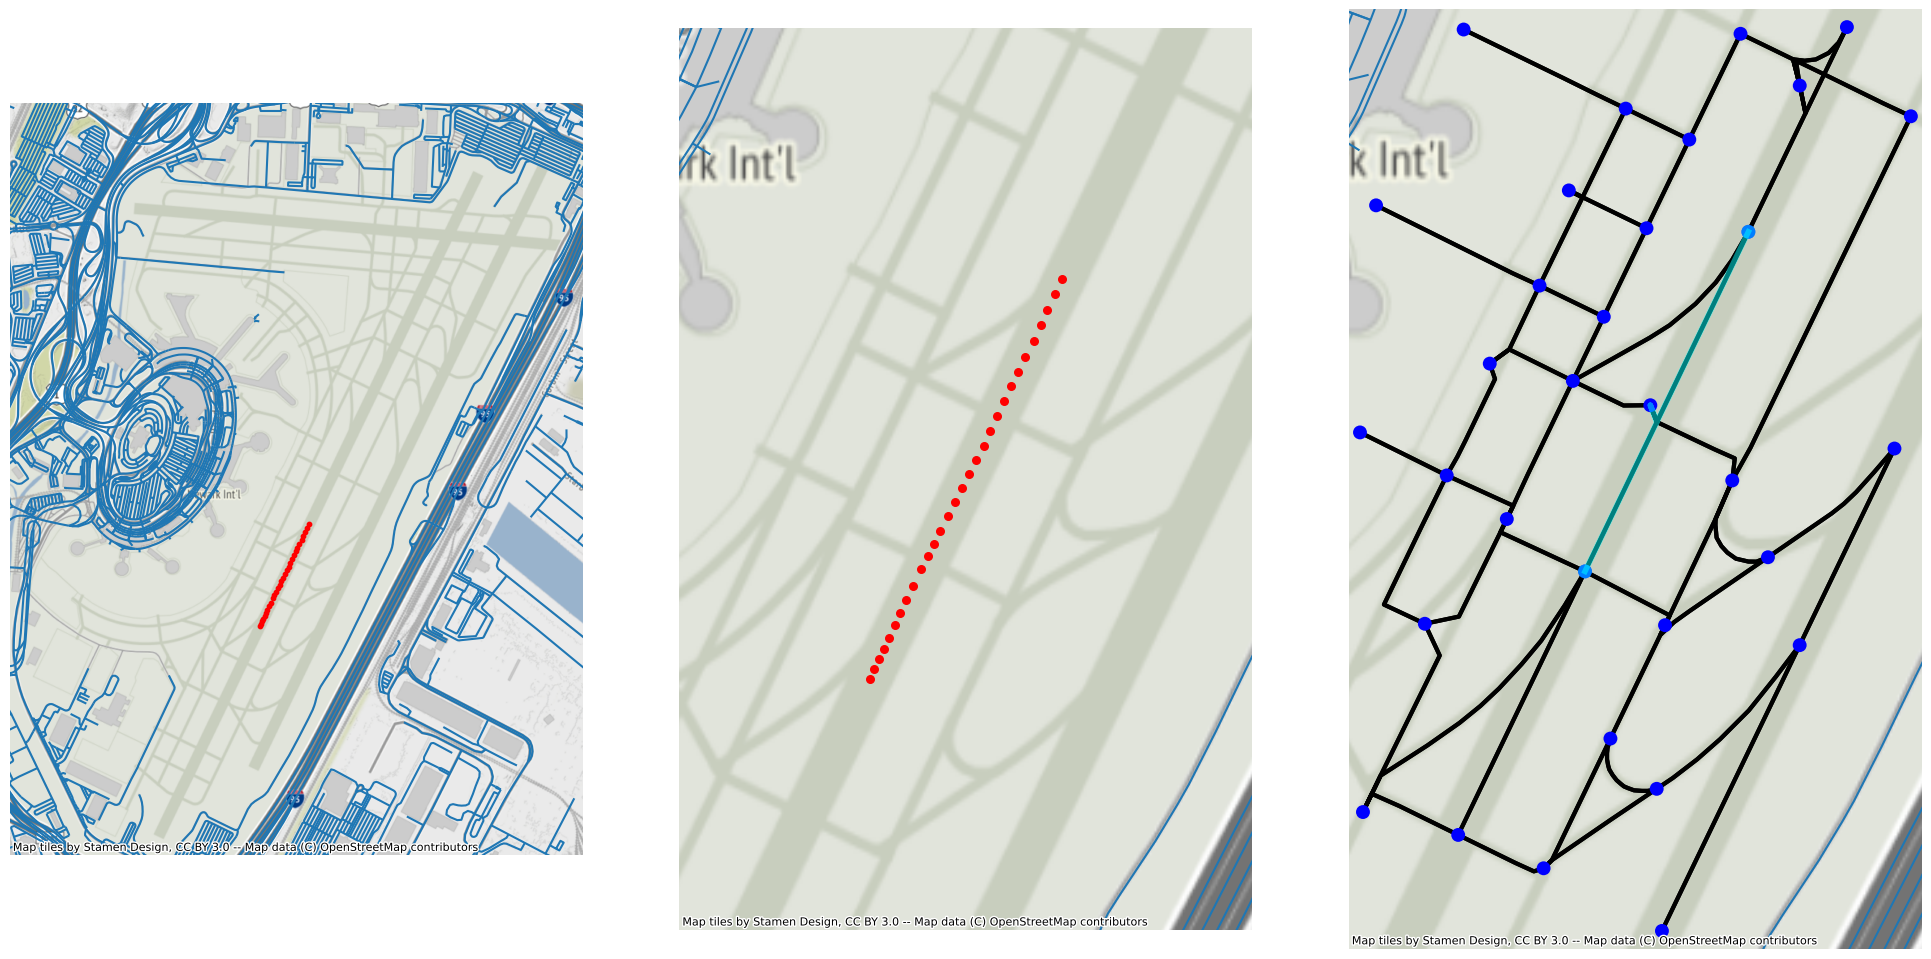

In [24]:
fig, ax = plt.subplots(1, 3, figsize = (20, 45))

# plot map 
gdf = gpd.read_file(MAP_FILE)
gd = gdf.to_crs(epsg=ESPG)
gd.plot(ax=ax[0])
gd.plot(ax=ax[1])
gd.plot(ax=ax[2])

ax[0].set_xlim(xmin=LON_MIN, xmax=LON_MAX)
ax[0].set_ylim(ymin=LAT_MIN, ymax=LAT_MAX)

plt.tight_layout()
ctx.add_basemap(ax[0], crs=gdf.crs,)
ctx.add_basemap(ax[1], crs=gdf.crs,)
ctx.add_basemap(ax[2], crs=gdf.crs,)

# create airports graph
graph_filter = '["aeroway"~"runway|taxiway|stopway"]'
airport_graph = ox.graph_from_place(
    AIRPORT_NAME, simplify=True, retain_all=True, truncate_by_edge=True, buffer_dist=1000, 
    custom_filter=graph_filter
)
ox.plot_graph(
    airport_graph, ax=ax[0], bgcolor="white", edge_color='black', edge_linewidth=1,
    node_size=30, node_color='blue', show=False, bbox=LIMITS_BBOX)
ax[0].invert_yaxis()
ax[0].invert_xaxis()

ox.plot_graph(
    airport_graph, ax=ax[1], bgcolor="white", edge_color='black', edge_linewidth=3,
    node_size=50, node_color='blue', show=False, bbox=LIMITS_BBOX)
ax[1].invert_yaxis()
ax[1].invert_xaxis()

# ox.plot_graph(
#     airport_graph, ax=ax[2], bgcolor="white", edge_color='black', edge_linewidth=3,
#     node_size=50, node_color='blue', show=False, bbox=LIMITS_BBOX)
# ax[2].invert_yaxis()
# ax[2].invert_xaxis()
ax[2].invert_yaxis()
ax[2].invert_xaxis()

unique_IDs = data.ID.unique()

offset = 0.003
num_trajs = 10
for n, ID in enumerate(unique_IDs):
    if n > num_trajs:
        break

    traj = data[:][data.ID == ID]    
    if n < num_trajs:
        continue
    # print(traj.shape)
    traj = traj[:30]
    geometry = [Point(xy) for xy in zip(traj.Lon, traj.Lat)]
    
    # plot raw trajectory 
    lon_min, lon_max = min(traj.Lon) - offset, max(traj.Lon) + offset
    lat_min, lat_max = min(traj.Lat) - offset, max(traj.Lat) + offset
    bbox = (lat_min, lat_max, lon_min, lon_max)

    ax[1].set_xlim(xmin=lon_min, xmax=lon_max)
    ax[1].set_ylim(ymin=lat_min, ymax=lat_max)

    ax[2].set_xlim(xmin=lon_min, xmax=lon_max)
    ax[2].set_ylim(ymin=lat_min, ymax=lat_max)

    # plot graph-based trajectory
    bbox_graph = ox.graph_from_bbox(
        north=lat_max, south=lat_min, east=lon_min, west=lon_max, simplify=True, retain_all=False, 
        custom_filter=graph_filter)
    
    bbox_graph = ox.consolidate_intersections(
        bbox_graph, tolerance=0.00040, rebuild_graph=True, dead_ends=True, reconnect_edges=True)

    ox.plot_graph(
        bbox_graph, ax=ax[2], bgcolor="white", edge_color='black', edge_linewidth=3,
        node_size=100, node_color='blue', show=False)

    nn, dist = ox.distance.nearest_nodes(bbox_graph, traj.Lon, traj.Lat, return_dist=True)
    dist = np.asarray(dist)
    idx = dist < 70
    dist = dist[idx].tolist()
    nn = np.asarray(nn)[idx].tolist()
    nn = [n[0] for n in groupby(nn)]

    on = nn[:-1]
    dn = nn[1:]

    routes = []
    for o, d in zip(on, dn):
        # Pairwise starts and ends
        path = ox.distance.shortest_path(bbox_graph, o, d)
        routes += path[:-1]
    routes += [path[-1]]

    gdf = GeoDataFrame(traj, geometry=geometry, crs=CRS, copy = False)
    gdf.plot(ax=ax[0], color='red', markersize=10)
    gdf.plot(ax=ax[1], color='red', markersize=30)
    
    ox.plot_graph_route(
        bbox_graph, routes, bgcolor="white", edge_color='black', edge_linewidth=2, node_size=100,
        node_color='blue', route_color='cyan', bbox=bbox, show=True, ax=ax[2]
    )
fig.savefig(f"{OUTPUT_DIR}/dummy.png", dpi=600, bbox_inches='tight')

In [25]:
def compute_route(G, trajectory, distance_threshold = 70):
    nn, dist = ox.distance.nearest_nodes(G, trajectory.Lon, trajectory.Lat, return_dist=True)
    dist = np.asarray(dist)
    idx = dist < distance_threshold
    dist = dist[idx].tolist()
    nn = np.asarray(nn)[idx].tolist()
    nn = [n[0] for n in groupby(nn)]
    
    if len(nn) <= 1:
        return []
    
    on = nn[:-1]
    dn = nn[1:]

    route = []
    path = None
    for o, d in zip(on, dn):
        # Pairwise starts and ends
        path = ox.distance.shortest_path(G, o, d)
        route += path[:-1]
    if not path is None:
        route += [path[-1]]
    
    return route

def compute_local_graph(lat_min, lat_max, lon_min, lon_max, osm_filter, tolerance = 0.0004, reduce=True):
    G = ox.graph_from_bbox(
        north=lat_max, south=lat_min, east=lon_min, west=lon_max, simplify=True, 
        retain_all=False, custom_filter=osm_filter)
    if reduce:
        G = ox.consolidate_intersections(
            G, tolerance=tolerance, rebuild_graph=True, dead_ends=True, reconnect_edges=True)
    return G

In [26]:
%matplotlib agg

AIRPORT_FILTER = '["aeroway"~"runway|taxiway|stopway"]'
airport_graph = ox.graph_from_place(
    AIRPORT_NAME, simplify=True, retain_all=True, truncate_by_edge=True, buffer_dist=1000, 
    custom_filter=AIRPORT_FILTER
)

gdf = gpd.read_file(MAP_FILE)
gd = gdf.to_crs(epsg=ESPG)

# gdf = gpd.read_file(MAP_FILE)
# gd = gdf.to_crs(epsg=ESPG)
# gd.plot(ax=ax[0])
# gd.plot(ax=ax[1])
# gd.plot(ax=ax[2])

offset = 0.003
num_files = 100
num_trajectories = 1
trajectory_length = 30
tolerance = 0.0004
reduce = True

# fig, ax = plt.subplots(1, 2, figsize = (20, 30))
fig, ax = plt.subplots(figsize = (20, 30))

for i, trajectory_file in enumerate(tqdm(TRAJECTORY_FILES)):
    if i > num_files:
        break
    plt.tight_layout()
    
    data = pd.read_csv(trajectory_file)
    unique_IDs = data.ID.unique()

    for n, ID in enumerate(unique_IDs):
        if n > num_trajectories:
            break
        
        trajectory = data[:][data.ID == ID]    
        if n < num_trajectories:
            continue

        if trajectory.shape[0] < trajectory_length:
            continue
        trajectory = trajectory[:trajectory_length]

        # get limits of trajectory 
        lon_min, lon_max = min(trajectory.Lon) - offset, max(trajectory.Lon) + offset
        lat_min, lat_max = min(trajectory.Lat) - offset, max(trajectory.Lat) + offset
        bbox = (lat_min, lat_max, lon_min, lon_max)

        # get local graph 
        G_bbox = compute_local_graph(lat_min, lat_max, lon_min, lon_max, AIRPORT_FILTER, tolerance)
        
        # compute route on local graph 
        route = compute_route(G_bbox, trajectory)
        if len(route) <= 0:
            continue
        
        # get trajectory in a geopandas dataframe
        geometry = [Point(xy) for xy in zip(trajectory.Lon, trajectory.Lat)]

        # plot 
        gd.plot(ax=ax)
        ctx.add_basemap(ax, crs=gdf.crs)
        ax.set_xlim(xmin=lon_min, xmax=lon_max)
        ax.set_ylim(ymin=lat_min, ymax=lat_max)
        gdf = GeoDataFrame(trajectory, geometry=geometry, crs=CRS, copy = False)
        gdf.plot(ax=ax, color='red', markersize=30)
        ox.plot_graph(
            G_bbox, ax=ax, bgcolor="white", edge_color='black', edge_linewidth=3, node_size=100, 
            node_color='blue', show=False)
        ax.invert_yaxis(); ax.invert_xaxis()

        # # plot 
        # gd.plot(ax=ax[0])
        # ctx.add_basemap(ax[0], crs=gdf.crs)
        # ax[0].set_xlim(xmin=lon_min, xmax=lon_max)
        # ax[0].set_ylim(ymin=lat_min, ymax=lat_max)
        # gdf = GeoDataFrame(trajectory, geometry=geometry, crs=CRS, copy = False)
        # gdf.plot(ax=ax[0], color='red', markersize=30)
        # ox.plot_graph(
        #     G_bbox, ax=ax[0], bgcolor="white", edge_color='black', edge_linewidth=3, node_size=100, 
        #     node_color='blue', show=False)
        # ax[0].invert_yaxis(); ax[0].invert_xaxis()

        # gd.plot(ax=ax[1])
        # ctx.add_basemap(ax[1], crs=gdf.crs)  
        # ax[1].set_xlim(xmin=lon_min, xmax=lon_max)
        # ax[1].set_ylim(ymin=lat_min, ymax=lat_max)
        # ox.plot_graph(
        #     G_bbox, ax=ax[1], bgcolor="white", edge_color='black', edge_linewidth=3, node_size=100, 
        #     node_color='blue', show=True)
        # ox.plot_graph_route(
        #     G_bbox, route, bgcolor="white", edge_color='black', edge_linewidth=2, node_size=100,
        #     node_color='blue', route_color='cyan', bbox=bbox, show=True, ax=ax[1]
        # )
        # ax[1].invert_yaxis(); ax[1].invert_xaxis()
        fig.savefig(
            f"{OUTPUT_DIR}/file-{i}_trajectory-{n}_{int(reduce)}.png", dpi=100, bbox_inches='tight')
        plt.cla()


  0%|          | 0/1022 [00:00<?, ?it/s]/home/khalo/miniconda3/envs/boeing/lib/python3.9/site-packages/osmnx/simplification.py:458: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/home/khalo/miniconda3/envs/boeing/lib/python3.9/site-packages/osmnx/simplification.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid
  0%|          | 2/1022 [00:01<14:53,  1.14it/s]/home/khalo/miniconda3/envs/boeing/lib/python3.9/site-packages/osmnx/simplification.py:458: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometr